<a href="https://colab.research.google.com/github/Vizzuality/mangrove-atlas-data/blob/master/create_gadm_eez_boundaries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prepare data for the mangrove atlas project

https://github.com/Vizzuality/mangrove-atlas-data

`Edward P. Morris (vizzuality.)`
`Oscar Esbri (vizzuality.)`

## TODO
+ Use the global_islands dataset to add islands missing from GADM 3.6.
+ Update terrestrial territories with overlapping claims.

## Description
This notebook creates a fusion of the Database of Global Administrative Areas admin 0, i.e., countries/states ([GADM](http://gadm.org/)) 
and Exclusive Economic Zones ([EEZ](http://www.marineregions.org/eezmapper.php)), and attempts to ensure a consitent naming related to the UN list of soverign states. As the general aim is to create a continuous polygon for each state for doing zonal statistics, we attempt to remove all inner "holes" in the representation of the state, e.g., create a representation of the total boundary of the territory.

### Lakes, islands and coastal resolution, and gaps
The two main datasets use different resolution data for the coasts, including the resolution of islands, hence combining them leads to some gaps. GADM does not have gaps for lakes although the Caspain sea (whose status as a lake is disputed) is included. The EEZ dataset is generally higher resolution and includes lots of small islands not shown in GADM. As stated above we try to remove these gaps so as to create a continuous polygon. This is complicated where there are overlapping claims. 

### Geometries with overlapping claims
Our practial approach is to first attempt to match all land and marine geometries that are inclded in the [UN M.49 list of geoareas](https://unstats.un.org/SDGAPI/swagger/#!/GeoArea/V1SdgGeoAreaListGet), which appear to have no overlapping claims; although it should be noted that thorough checks were not made. We then add terrestrial and marine geometries with joint regimes and overlapping claims, assigning information from the original databases, and made small corrections using information from the UN M49 FAQ. 

+ GADM level 0 has no specific indications of geometries with overlapping claims, apart from including a limited number of geometries with 'X--' [ISO 3166-1 alpha-3](https://en.wikipedia.org/wiki/ISO_3166-1_alpha-3) codes in the `GID_0` field.

+ The EEZ layer has details about EEZ that are either under `Joint regime`, shared by states, or `Overlapping claims` with details of up to 3 claiments (using ISO 3166-1 alpha-3 codes).

#### Further info about overlapping claims
+ Marine regions has [detailed information](http://www.marineregions.org/eezmethodology.php) about the methodolgy they used to define EEZs.
+ According to [UN M49 countries classification](https://unstats.un.org/unsd/methodology/m49/) FAQ Taiwan is considered part of China (numerical code 156)
+ According to [UN M49 countries classification](https://unstats.un.org/unsd/methodology/m49/) FAQ Kosovo is considered part of Serbia (numerical code 688)
+ The [UN list of Non-Self-Governing_Territories](https://en.wikipedia.org/wiki/United_Nations_list_of_Non-Self-Governing_Territories#Current_entries)
+ A resource useful for understanding the number of regions with overlapping claims is http://metrocosm.com/disputed-territories-map.html .
+ The Natural earth [disputed areas layer](https://www.naturalearthdata.com/downloads/10m-cultural-vectors/10m-admin-0-breakaway-disputed-areas/), although this seems to include some regions no longer disputed.
+ https://en.wikipedia.org/wiki/List_of_territorial_disputes 

#### Other curiosities
+ [Quita Sueño](https://en.wikipedia.org/wiki/Quita_Sue%C3%B1o_Bank) is a reef that appears as a large gap in the EEZ, but is not land in GADM.

**The assignment of countries or areas to specific groupings is for statistical convenience and does not imply any assumption regarding political or other affiliation of countries or territories by the Authors.**

### Output data table

| Name       | dtype | Description                                                                            |
|------------|-------|----------------------------------------------------------------------------------------|
| gid        | str   | Identification code, useally unchanged from the original data source                   |
| geoname    | str   | Geographical name of the geometry                                                      |
| iso3       | str   | ISO-3611 alpha-3 code for the geometry, if it exists.                                  |
| un_code    | int   | UN M4.9 country or area code for the geometry, if it exists.                           |
| domain     | str   | Classification if the geometry is in the terrestrial or marine domain                  |
| type_level | str   | Domain specific classification of the geometry, e.g., Admin. level 0 or EEZ 200NM      |
| source     | str   | Name of the original data source                                                       |
| status     | str   | Status of the geometry, e.g., No overlapping claim, Joint regime, or Overlapping claim |
| claimed_by | str   | Comma de-limited list of ISO-3611 alpha-3 codes of the states that claim the geometry  |
| geometry   | str   | WKT polygon or multi-polygon geometry string                                           |



```
MIT License

Copyright (c) 2020 Vizzuality

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.
```

# Setup

## Linux dependencies

In [14]:
%%bash
apt install -q -y libspatialindex-dev libproj-dev proj-data proj-bin libgeos-dev
npm install -g mapshaper

Reading package lists...
Building dependency tree...
Reading state information...
proj-data is already the newest version (4.9.3-2).
proj-data set to manually installed.
The following additional packages will be installed:
  libspatialindex-c4v5 libspatialindex4v5
Suggested packages:
  libgdal-doc
The following NEW packages will be installed:
  libgeos-dev libproj-dev libspatialindex-c4v5 libspatialindex-dev
  libspatialindex4v5 proj-bin
0 upgraded, 6 newly installed, 0 to remove and 25 not upgraded.
Need to get 860 kB of archives.
After this operation, 5,014 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libgeos-dev amd64 3.6.2-1build2 [73.1 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex4v5 amd64 1.8.5-5 [219 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libspatialindex-c4v5 amd64 1.8.5-5 [51.7 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libproj-dev amd64 4



npm WARN optional SKIPPING OPTIONAL DEPENDENCY: fsevents@2.1.2 (node_modules/mapshaper/node_modules/fsevents):
npm WARN notsup SKIPPING OPTIONAL DEPENDENCY: Unsupported platform for fsevents@2.1.2: wanted {"os":"darwin","arch":"any"} (current: {"os":"linux","arch":"x64"})



## Python packages

In [0]:
%%bash
pip install -q rtree pygeos fiona geopandas country_converter gcsfs zarr xarray rioxarray folium
#xclim gcsfs zarr geopandas rioxarray netcdf4 nc-time-axis cftime regionmask

In [0]:
# Check shapely speedups are available
from shapely import speedups
speedups.enabled

In [16]:
!pip list

Package                  Version        
------------------------ ---------------
absl-py                  0.9.0          
affine                   2.3.0          
alabaster                0.7.12         
albumentations           0.1.12         
altair                   4.1.0          
asciitree                0.3.3          
asgiref                  3.2.7          
astor                    0.8.1          
astropy                  4.0.1.post1    
astunparse               1.6.3          
atari-py                 0.2.6          
atomicwrites             1.3.0          
attrs                    19.3.0         
audioread                2.1.8          
autograd                 1.3            
Babel                    2.8.0          
backcall                 0.1.0          
beautifulsoup4           4.6.3          
bleach                   3.1.4          
blis                     0.4.1          
bokeh                    1.4.0          
boto                     2.49.0         
boto3           

## Authorisation

In [0]:
# For auth WITHOUT service account
#from google.colab import auth
#auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
#project_id = "mangrove-atlas-246414"
#!gcloud config set project {project_id}

In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Copy GC credentials to home (place in your GDrive, and connect Drive)
!cp "/content/drive/My Drive/mangrove-atlas-246414-2f33cc439deb.json" "/root/.mangrove-atlas-246414-2f33cc439deb.json"

In [20]:
# Auth WITH service account
!gcloud auth activate-service-account \
  edward-morris-vizzuality-com-d@mangrove-atlas-246414.iam.gserviceaccount.com \
          --key-file=/root/.mangrove-atlas-246414-2f33cc439deb.json --project="mangrove-atlas-246414"


Activated service account credentials for: [edward-morris-vizzuality-com-d@mangrove-atlas-246414.iam.gserviceaccount.com]


In [21]:
# Test GC auth
!gsutil ls "gs://mangrove_atlas"

gs://mangrove_atlas/boundaries/
gs://mangrove_atlas/ee-export-tables/
gs://mangrove_atlas/ee-upload-manifests/
gs://mangrove_atlas/elevation/
gs://mangrove_atlas/environmental-pressures/
gs://mangrove_atlas/gadm-eez.zarr/
gs://mangrove_atlas/land-cover/
gs://mangrove_atlas/mangrove-properties/
gs://mangrove_atlas/orthoimagery/
gs://mangrove_atlas/physical-environment/
gs://mangrove_atlas/tilesets/


In [22]:
# Clean up
!rm -r sample_data

rm: cannot remove 'sample_data': No such file or directory


# Utils

## copy_gcs

In [0]:
import os
import subprocess

def copy_gcs(source_list, dest_list, opts=""):
  """
  Use gsutil to copy each corresponding item in source_list
  to dest_list

  """
  for s, d  in zip(source_list, dest_list):
    cmd = f"gsutil -m cp -r {opts} {s} {d}"
    print(f"Processing: {cmd}")
    r = subprocess.call(cmd, shell=True)
    if r == 0:
        print("Task created")
    else:
        print("Task failed")
  print("Finished copy")

## concat_strs

In [0]:
def concat_strs(*args, sep = ", "):
    # Filter NULLs
    nonnull_args = [str(arg).strip() for arg in args if arg]
    # Filter blanks  
    good_args = [arg for arg in nonnull_args if arg]          
    retval = sep.join(good_args)
    return retval

## bounds_to_polygon

In [0]:
def bounds_to_polygon(bounds):
    """ Returns Shapely polygon of bounds

    Args:
        bounds (iterable): bounds (left bottom right top)

    Returns:
        shapely.geometry.Polygon: polygon of bounds

    """
    return shapely.geometry.Polygon([
        (bounds[0], bounds[1]),
        (bounds[2], bounds[1]),
        (bounds[2], bounds[3]),
        (bounds[0], bounds[3])
    ])

## interior_to_polygon

In [0]:
from shapely.geometry import Polygon

def interior_to_polygon(gds):
  # check geometry is a polygon 
  if tst.geom_type.tolist()[0] == 'Polygon':
    # check it contains a ring
    if gds.is_ring.any():
      # extract shapely LinearRing
      out = Polygon(tst.interiors.tolist()[0][0])
    else:
      print("No interior ring")
      out = "NA"
  else:
    print("Requires a Polygon")
    out = "NA"     
  return out
 

## exterior_to_polygon

In [0]:
from shapely.geometry import Polygon

def exterior_to_polygon(gds):
  # check geometry is a polygon 
  if tst.geom_type.tolist()[0] == 'Polygon':
    # check it contains a ring
    if gds.is_ring.any():
      # extract shapely LinearRing
      out = Polygon(tst.exterior.tolist()[0])
    else:
      print("No exterior ring")
      out = "NA"
  else:
    print("Requires a Polygon")
    out = "NA"     
  return out
 

## gdf_to_xarray

In [0]:
import shapely

def gdf_to_xarray(gdf, coords, dims, chunk, attrs):
  
  # Convert geoms to WKT binary hex 
  geoms = gdf.apply(lambda x: shapely.wkb.dumps(x.geometry, hex=True), axis=1)
  gdf.loc[:,'geometry'] = geoms

  # Set multiindex
  gdf = gdf.set_index(dims)

  # Convert to xarray
  gda = gdf.to_xarray()

  # Set coords
  gda = gda.set_coords(coords)

  # Set attributes
  gda = gda.assign_attrs(attrs)
  
  return gda.chunk(chunk)
 

## write_to_remote_zarr

In [0]:
import gcsfs
import zarr
import xarray as xr
# Set display to HTML sytle (optional)
xr.set_options(display_style='html', display_width=80)

def write_to_remote_zarr(
    ds,
    group,
    root,
    project_id = "mangrove-atlas-246414",
    token="/root/.mangrove-atlas-246414-2f33cc439deb.json"
    ):
  
  # Connect to GS
  gc = gcsfs.GCSFileSystem(project=project_id, token=token)
  store = gc.get_mapper(root, check=False, create=True)
  
  # Write to zarr group
  ds.to_zarr(store=store, group=group, mode="w", consolidated=True)
  # consolidate metadata at root
  zarr.consolidate_metadata(store)
  c = gc.exists(f"{root}/.zmetadata")
  print(f"{root} is consoldiated? {c}")
  with zarr.open(store, mode='r') as z:
    print(z.tree())



## get_cached_remote_zarr

In [0]:
import gcsfs
import zarr
import xarray as xr

def get_cached_remote_zarr(
    group,
    root,
    project_id = "mangrove-atlas-246414",
    token="/root/.mangrove-atlas-246414-2f33cc439deb.json",
    clear_cache=False):
  
  # Connect to GS
  gc = gcsfs.GCSFileSystem(project=project_id, token=token)
  store = gc.get_mapper(root, check=False, create=False)
  # Check zarr is consolidated
  consolidated = gc.exists(f'{root}/.zmetadata')
  # Cache the zarr store
  #store = zarr.ZipStore(store, mode='r')
  cache = zarr.LRUStoreCache(store, max_size=None)
  if clear_cache:
    cache = cache.invalidate()
  # Return cached zarr group
  return xr.open_zarr(cache, group=group, consolidated=consolidated)

## get_gda_geoms

In [0]:
import geopandas as gpd
import shapely

def get_gda_geoms(group, select_by=None, root = "copernicus-climate/ref-nuts-2016-01m.zarr"):
  gda = get_cached_remote_zarr(group, root = root)
  # Select
  if select_by:
    gda = gda.sel(select_by, drop=True)
  df = gda.reset_coords().to_dataframe().dropna().reset_index()
  geoms = df.geometry
  # Return as geopandas object, converting geometry to shapley objects
  return gpd.GeoDataFrame(df, geometry=[shapely.wkb.loads(g, True) for g in geoms])


# Processing

## Get datasets

### Database of Global Administrative Areas (GADM) version 3.6

"name": "Database of Global Administrative Areas (GADM), version 3.6"


In [0]:
import requests

# GADM levels verion 3.6
url = "https://biogeo.ucdavis.edu/data/gadm3.6/gadm36_levels_gpkg.zip"

def download_url(url, save_path, chunk_size=512):
    r = requests.get(url, stream=True)
    with open(save_path, 'wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)
download_url(url, 'gadm36_levels_gpkg.zip')

In [36]:
# Unzip
!unzip gadm36_levels_gpkg.zip 

Archive:  gadm36_levels_gpkg.zip
  inflating: gadm36_levels.gpkg      
  inflating: license.txt             


In [37]:
# See the layers
import fiona
print(fiona.listlayers('/content/gadm36_levels.gpkg'))

['level0', 'level1', 'level2', 'level3', 'level4', 'level5']


In [38]:
# Open convert to SHP, fix topological errors and open as gdf
import geopandas as gpd
tmp = gpd.read_file('/content/gadm36_levels.gpkg', layer='level0')
# Write to ESRI SHP
tmp.to_file("gadm-0_version-3-6.shp", driver='ESRI Shapefile')
# Fix topolgical errors
# see https://github.com/mbloch/mapshaper/wiki/Command-Reference#-clean
!mapshaper-xl -i snap gadm-0_version-3-6.shp -clean gap-fill-area=30km2 -o format=shapefile gadm-0_version-3-6.shp force
# Open as gdf
gadm36_0 = gpd.read_file('gadm-0_version-3-6.shp')

Allocating 8 GB of heap memory
[i] Snapped 4841 points
[clean] Closed 58 / 60 gaps using 30+ sqkm variable threshold
[clean] Retained 256 of 256 features
[o] Wrote gadm-0_version-3-6.shp
[o] Wrote gadm-0_version-3-6.shx
[o] Wrote gadm-0_version-3-6.dbf
[o] Wrote gadm-0_version-3-6.prj


In [39]:
# Add UN M49 code
import country_converter as coco
import numpy as np
cc = coco.CountryConverter()
iso3 = gadm36_0['GID_0'].tolist()
print(iso3)
gadm36_0['un_code'] = cc.convert(names=iso3, src = 'ISO3', to='UNcode', not_found=np.nan)
gadm36_0


['ABW', 'AFG', 'AGO', 'AIA', 'ALA', 'ALB', 'AND', 'ARE', 'ARG', 'ARM', 'ASM', 'ATA', 'ATF', 'ATG', 'AUS', 'AUT', 'AZE', 'BDI', 'BEL', 'BEN', 'BES', 'BFA', 'BGD', 'BGR', 'BHR', 'BHS', 'BIH', 'BLM', 'BLR', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'BRN', 'BTN', 'BVT', 'BWA', 'CAF', 'CAN', 'CCK', 'CHE', 'CHL', 'CHN', 'CIV', 'CMR', 'COD', 'COG', 'COK', 'COL', 'COM', 'CPV', 'CRI', 'CUB', 'CUW', 'CXR', 'CYM', 'CYP', 'CZE', 'DEU', 'DJI', 'DMA', 'DNK', 'DOM', 'DZA', 'ECU', 'EGY', 'ERI', 'ESH', 'ESP', 'EST', 'ETH', 'FIN', 'FJI', 'FLK', 'FRA', 'FRO', 'FSM', 'GAB', 'GBR', 'GEO', 'GGY', 'GHA', 'GIB', 'GIN', 'GLP', 'GMB', 'GNB', 'GNQ', 'GRC', 'GRD', 'GRL', 'GTM', 'GUF', 'GUM', 'GUY', 'HKG', 'HMD', 'HND', 'HRV', 'HTI', 'HUN', 'IDN', 'IMN', 'IND', 'IOT', 'IRL', 'IRN', 'IRQ', 'ISL', 'ISR', 'ITA', 'JAM', 'JEY', 'JOR', 'JPN', 'KAZ', 'KEN', 'KGZ', 'KHM', 'KIR', 'KNA', 'KOR', 'KWT', 'LAO', 'LBN', 'LBR', 'LBY', 'LCA', 'LIE', 'LKA', 'LSO', 'LTU', 'LUX', 'LVA', 'MAC', 'MAF', 'MAR', 'MCO', 'MDA', 'MDG', 'MDV', 'MEX'

,GID_0,NAME_0,geometry,un_code
0,ABW,Aruba,"POLYGON ((-69.97820 12.46986, -69.97847 12.469...",533.0
1,AFG,Afghanistan,"POLYGON ((60.89944 29.83750, 60.89880 29.83780...",4.0
2,AGO,Angola,"MULTIPOLYGON (((11.73347 -16.67255, 11.73347 -...",24.0
3,AIA,Anguilla,"MULTIPOLYGON (((-63.42375 18.58903, -63.42375 ...",660.0
4,ALA,Ã land,"MULTIPOLYGON (((21.32195 59.74986, 21.32195 59...",248.0
...,...,...,...,...
251,XSP,Spratly Islands,"MULTIPOLYGON (((114.35472 11.45139, 114.35416 ...",NaN
252,YEM,Yemen,"MULTIPOLYGON (((53.26931 12.12875, 53.26931 12...",887.0
253,ZAF,South Africa,"MULTIPOLYGON (((19.42097 -34.67903, 19.42097 -...",710.0
254,ZMB,Zambia,"POLYGON ((23.42815 -17.63928, 23.42766 -17.636...",894.0


In [40]:
import numpy as np
# GADM36 items without UN CODE
gadm36_0.loc[gadm36_0['un_code'].isnull()]

,GID_0,NAME_0,geometry,un_code
228,TWN,Taiwan,"MULTIPOLYGON (((116.71722 20.70959, 116.71778 ...",NaN
245,XAD,Akrotiri and Dhekelia,"MULTIPOLYGON (((32.76053 34.65708, 32.76010 34...",NaN
246,XCA,Caspian Sea,"POLYGON ((48.87939 38.43700, 48.87820 38.47082...",NaN
247,XCL,Clipperton Island,"POLYGON ((-109.22542 10.32042, -109.22542 10.3...",NaN
248,XKO,Kosovo,"POLYGON ((20.56959 41.78654, 20.57300 41.78707...",NaN
249,XNC,Northern Cyprus,"MULTIPOLYGON (((32.63295 35.18930, 32.63260 35...",NaN
250,XPI,Paracel Islands,"MULTIPOLYGON (((112.25397 16.99448, 112.25665 ...",NaN
251,XSP,Spratly Islands,"MULTIPOLYGON (((114.35472 11.45139, 114.35416 ...",NaN


### Marine Regions - Exclusive Economic Zones version 11

Available via WFS http://geo.vliz.be/geoserver/MarineRegions/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=MarineRegions:eez 

"name": "Maritime Boundaries Geodatabase: Maritime Boundaries and Exclusive Economic Zones (200NM)"

"citation": "Flanders Marine Institute (2019). Maritime Boundaries Geodatabase: Maritime Boundaries and Exclusive Economic Zones (200NM), version 11. Available online at http://www.marineregions.org/. https://doi.org/10.14284/386"

"description": "Maritime Boundaries and Exclusive Economic Zones from the VLIZ Maritime Boundaries Geodatabase. Boundaries have been built using information about treaties between coastal countries. When treaties are not available, median lines have been calculated. An exclusive economic zone (EEZ) is a seazone extending from a state's coast or baseline over which the state has special rights over the exploration and use of marine resources. Generally a state's EEZ extends 200 nautical miles out from its coast, except where resulting points would be closer to another country. This dataset also contains delimitation of overlapping claims and joint regimes. In the Maritime Boundaries Geodatabase, Marine Regions makes available most of the maritime areas defined in the Law of the Sea Convention: Exclusive Economic Zones (EEZ), Territorial Seas (TS), Contiguous Zones (CZ), Internal Waters (IW) and Archipelagic Waters (AW)."

In [41]:
import geopandas as gpd

# Get data from WFS
tmp = gpd.read_file('http://geo.vliz.be/geoserver/MarineRegions/ows?service=WFS&version=1.0.0&request=GetFeature&typeName=MarineRegions:eez')
# Write to ESRI SHP
tmp.to_file("eez-200NM_version-11-0.shp", driver='ESRI Shapefile')
# Fix topological errors
!mapshaper-xl -i snap eez-200NM_version-11-0.shp -clean -clean gap-fill-area=30km2 -o format=shapefile eez-200NM_version-11-0.shp force
# Open as gdf
eez = gpd.read_file('eez-200NM_version-11-0.shp')
eez

Allocating 8 GB of heap memory
[i] Snapped 19858 points
[clean] Closed 112,412 / 218,595 gaps using 0.026+ sqkm variable threshold
[clean] Retained 271 of 281 features
[clean] Closed 104,393 / 106,183 gaps using 30+ sqkm variable threshold
[clean] Retained 271 of 271 features
[o] Wrote eez-200NM_version-11-0.shp
[o] Wrote eez-200NM_version-11-0.shx
[o] Wrote eez-200NM_version-11-0.dbf
[o] Wrote eez-200NM_version-11-0.prj


,gml_id,mrgid,geoname,mrgid_ter1,pol_type,mrgid_sov1,territory1,iso_ter1,sovereign1,mrgid_ter2,mrgid_sov2,territory2,iso_ter2,sovereign2,mrgid_ter3,mrgid_sov3,territory3,iso_ter3,sovereign3,x_1,y_1,mrgid_eez,area_km2,iso_sov1,iso_sov2,iso_sov3,un_sov1,un_sov2,un_sov3,un_ter1,un_ter2,un_ter3,geometry
0,eez.278,62589,Chagos Archipelago Exclusive Economic Zone,8616,200NM,8614,Chagos Archipelago,None,Mauritius,0,0,None,None,None,0,0,None,None,None,72.00202,-6.53945,62589,650804,MUS,None,None,480,NaN,NaN,NaN,NaN,NaN,"POLYGON ((70.19643 -2.28834, 70.20279 -2.30015..."
1,eez.105,5688,Portuguese Exclusive Economic Zone,2243,200NM,2243,Portugal,PRT,Portugal,0,0,None,None,None,0,0,None,None,None,-10.92284,38.31921,5688,315501,PRT,None,None,620,NaN,NaN,620.0,NaN,NaN,"POLYGON ((-7.48092 37.49540, -7.48088 37.49512..."
2,eez.120,48970,Joint regime area Colombia / Dominican Republic,8640,Joint regime,8640,Dominican Republic,DOM,Dominican Republic,2175,2175,Colombia,COL,Colombia,0,0,None,None,None,-72.50386,15.01851,48970,13111,DOM,COL,None,214,170.0,NaN,214.0,170.0,NaN,"POLYGON ((-71.67074 15.01168, -71.67075 15.010..."
3,eez.121,48971,Overlapping claim: Venezuela / Colombia / Domi...,2175,Overlapping claim,2175,Colombia,COL,Colombia,8640,8640,Dominican Republic,DOM,Dominican Republic,2201,2201,Venezuela,VEN,Venezuela,-71.09015,15.05334,48971,869,COL,DOM,VEN,170,214.0,862.0,170.0,214.0,862.0,"POLYGON ((-71.67075 15.01038, -71.67074 15.011..."
4,eez.122,5681,Irish Exclusive Economic Zone,2114,200NM,2114,Ireland,IRL,Ireland,0,0,None,None,None,0,0,None,None,None,-11.74631,52.65269,5681,427039,IRL,None,None,372,NaN,NaN,372.0,NaN,NaN,"POLYGON ((-7.25544 55.06781, -7.25541 55.06787..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,eez.266,5677,French Exclusive Economic Zone,17,200NM,17,France,FRA,France,0,0,None,None,None,0,0,None,None,None,-1.96613,46.04212,5677,345240,FRA,None,None,250,NaN,NaN,250.0,NaN,NaN,"MULTIPOLYGON (((7.52987 43.78369, 7.52933 43.7..."
267,eez.267,8378,Algerian Exclusive Economic Zone,2152,200NM,2152,Algeria,DZA,Algeria,0,0,None,None,None,0,0,None,None,None,3.53979,37.20344,8378,131193,DZA,None,None,12,NaN,NaN,12.0,NaN,NaN,"POLYGON ((6.06655 38.80087, 6.43182 38.60378, ..."
268,eez.268,8400,Ghanaian Exclusive Economic Zone,2100,200NM,2100,Ghana,GHA,Ghana,0,0,None,None,None,0,0,None,None,None,-0.85027,3.50201,8400,227500,GHA,None,None,288,NaN,NaN,288.0,NaN,NaN,"MULTIPOLYGON (((-3.11200 5.11529, -3.11201 5.1..."
269,eez.269,8438,Greenlandic Exclusive Economic Zone,2260,200NM,2157,Greenland,GRL,Denmark,0,0,None,None,None,0,0,None,None,None,-31.97096,75.47965,8438,2268623,DNK,None,None,208,NaN,NaN,304.0,NaN,NaN,"POLYGON ((-57.27151 61.40984, -57.35028 62.001..."


In [42]:
eez['pol_type'].unique()

array(['200NM', 'Joint regime', 'Overlapping claim'], dtype=object)

In [43]:
# Joint regime EEZ items
eez.loc[eez['pol_type'] == 'Joint regime']

,gml_id,mrgid,geoname,mrgid_ter1,pol_type,mrgid_sov1,territory1,iso_ter1,sovereign1,mrgid_ter2,mrgid_sov2,territory2,iso_ter2,sovereign2,mrgid_ter3,mrgid_sov3,territory3,iso_ter3,sovereign3,x_1,y_1,mrgid_eez,area_km2,iso_sov1,iso_sov2,iso_sov3,un_sov1,un_sov2,un_sov3,un_ter1,un_ter2,un_ter3,geometry
2,eez.120,48970,Joint regime area Colombia / Dominican Republic,8640,Joint regime,8640,Dominican Republic,DOM,Dominican Republic,2175,2175,Colombia,COL,Colombia,0,0,None,None,None,-72.50386,15.01851,48970,13111,DOM,COL,None,214,170.0,NaN,214.0,170.0,NaN,"POLYGON ((-71.67074 15.01168, -71.67075 15.010..."
6,eez.132,48972,Joint regime area Honduras / Cayman Islands,2103,Joint regime,2103,Honduras,HND,Honduras,8638,2208,Cayman Islands,CYM,United Kingdom,0,0,None,None,None,-83.94222,18.70111,48972,2075,HND,GBR,None,340,826.0,NaN,340.0,136.0,NaN,"POLYGON ((-83.93333 18.41667, -84.20000 18.416..."
76,eez.45,21798,Protected Zone established under the Torres St...,2237,Joint regime,2237,Papua New Guinea,PNG,Papua New Guinea,2147,2147,Australia,AUS,Australia,0,0,None,None,None,142.41029,-9.50249,21798,3717,PNG,AUS,None,598,36.0,NaN,598.0,36.0,NaN,"POLYGON ((142.85111 -9.67350, 142.80445 -9.676..."
129,eez.114,48967,Joint regime area United Kingdom / Denmark (Fa...,2208,Joint regime,2208,United Kingdom,GBR,United Kingdom,3297,2157,Faeroe,FRO,Denmark,0,0,None,None,None,-7.51858,60.03609,48967,8011,GBR,DNK,None,826,208.0,NaN,826.0,234.0,NaN,"POLYGON ((-7.03208 60.14474, -6.75205 60.17359..."
130,eez.192,21797,Joint regime area Nigeria / Sao Tome and Principe,2238,Joint regime,2238,Sao Tome and Principe,STP,Sao Tome and Principe,2253,2253,Nigeria,NGA,Nigeria,0,0,None,None,None,5.58699,2.06760,21797,34534,STP,NGA,None,678,566.0,NaN,678.0,566.0,NaN,"POLYGON ((3.57583 1.92167, 3.89444 1.98139, 4...."
158,eez.131,21792,Joint regime area Colombia / Jamaica,8682,Joint regime,8682,Jamaica,JAM,Jamaica,2175,2175,Colombia,COL,Colombia,0,0,None,None,None,-79.14572,15.47035,21792,15247,JAM,COL,None,388,170.0,NaN,388.0,170.0,NaN,"POLYGON ((-78.63333 14.49361, -79.24193 14.966..."
167,eez.136,48974,Joint regime area Ecuador / Colombia,2166,Joint regime,2166,Ecuador,ECU,Ecuador,2175,2175,Colombia,COL,Colombia,0,0,None,None,None,-81.43712,1.46058,48974,18663,ECU,COL,None,218,170.0,NaN,218.0,170.0,NaN,"MULTIPOLYGON (((-83.53795 1.28963, -83.53790 1..."
236,eez.205,21796,Joint regime area Japan / Korea,8600,Joint regime,8600,South Korea,KOR,South Korea,2121,2121,Japan,JPN,Japan,0,0,None,None,None,127.57808,30.81396,21796,82610,KOR,JPN,None,410,392.0,NaN,410.0,392.0,NaN,"POLYGON ((127.69833 32.95000, 128.30000 32.950..."
246,eez.215,48977,Joint regime area Sweden / Norway,2252,Joint regime,2252,Norway,NOR,Norway,2180,2180,Sweden,SWE,Sweden,0,0,None,None,None,10.50095,58.80998,48977,140,NOR,SWE,None,578,752.0,NaN,578.0,752.0,NaN,"POLYGON ((10.59444 58.76147, 10.26814 58.77569..."
265,eez.265,48978,Joint regime area United States / Russia,2204,Joint regime,2204,United States,USA,United States,2240,2240,Russia,RUS,Russia,0,0,None,None,None,-16.90039,61.18062,48978,8521,USA,RUS,None,840,643.0,NaN,840.0,643.0,NaN,"MULTIPOLYGON (((167.44778 51.18944, 167.44800 ..."


In [44]:
# Overlapping claim EEZ items
eez.loc[eez['pol_type'] == 'Overlapping claim']

,gml_id,mrgid,geoname,mrgid_ter1,pol_type,mrgid_sov1,territory1,iso_ter1,sovereign1,mrgid_ter2,mrgid_sov2,territory2,iso_ter2,sovereign2,mrgid_ter3,mrgid_sov3,territory3,iso_ter3,sovereign3,x_1,y_1,mrgid_eez,area_km2,iso_sov1,iso_sov2,iso_sov3,un_sov1,un_sov2,un_sov3,un_ter1,un_ter2,un_ter3,geometry
3,eez.121,48971,Overlapping claim: Venezuela / Colombia / Domi...,2175,Overlapping claim,2175,Colombia,COL,Colombia,8640,8640,Dominican Republic,DOM,Dominican Republic,2201,2201,Venezuela,VEN,Venezuela,-71.09015,15.05334,48971,869,COL,DOM,VEN,170,214.0,862.0,170.0,214.0,862.0,"POLYGON ((-71.67075 15.01038, -71.67074 15.011..."
21,eez.28,48944,Overlapping claim Mayotte: France / Comoros,8606,Overlapping claim,17,Mayotte,MYT,France,8606,2163,Mayotte,MYT,Comores,0,0,None,None,None,45.30656,-13.21698,48944,66738,FRA,COM,None,250,174.0,0.0,175.0,175.0,0.0,"POLYGON ((43.48496 -14.46306, 43.49080 -14.453..."
22,eez.29,48946,Overlapping claim Ile Tromelin: Reunion / Mada...,8613,Overlapping claim,17,Ile Tromelin,None,France,8613,7963,Ile Tromelin,None,Madagascar,8613,8614,Ile Tromelin,None,Republic of Mauritius,54.67305,-15.71127,48946,274555,FRA,MDG,MUS,250,450.0,480.0,NaN,NaN,NaN,"POLYGON ((55.50556 -18.28639, 52.80000 -18.800..."
29,eez.4,8389,Overlapping claim Falkland / Malvinas Islands:...,8623,Overlapping claim,2208,Falkland / Malvinas Islands,FLK,United Kingdom,8623,2149,Falkland / Malvinas Islands,FLK,Argentina,0,0,None,None,None,-58.32237,-51.66703,8389,550566,GBR,ARG,None,826,32.0,NaN,238.0,238.0,NaN,"POLYGON ((-58.54196 -56.22782, -61.62049 -53.7..."
59,eez.50,48945,Overlapping claim Glorioso Islands: France / M...,8607,Overlapping claim,7963,Glorioso Islands,None,Madagascar,8607,17,Glorioso Islands,ATF,France,0,0,None,None,None,47.09690,-11.61810,48945,43506,MDG,FRA,None,450,250.0,NaN,NaN,260.0,NaN,"POLYGON ((46.68598 -12.80939, 46.67002 -12.783..."
61,eez.52,48948,Overlapping claim Matthew and Hunter Islands: ...,49593,Overlapping claim,17,Matthew and Hunter Islands,None,France,49593,2202,Matthew and Hunter Islands,None,Vanuatu,0,0,None,None,None,172.03655,-23.27911,48948,187184,FRA,VUT,None,250,548.0,NaN,NaN,NaN,NaN,"POLYGON ((170.55349 -25.61528, 170.33477 -23.9..."
67,eez.58,33176,Overlapping claim: Kenya / Somalia,2118,Overlapping claim,2118,Kenya,KEN,Kenya,2187,2187,Federal Republic of Somalia,SOM,Federal Republic of Somalia,0,0,None,None,None,43.90490,-2.28224,33176,50229,KEN,SOM,None,404,706.0,NaN,404.0,706.0,NaN,"POLYGON ((44.32959 -3.55439, 44.32931 -3.55421..."
94,eez.81,8365,Overlapping claim Gibraltarian Exclusive Econo...,3344,Overlapping claim,2208,Gibraltar,GIB,United Kingdom,2185,2185,Spain,ESP,Spain,0,0,None,None,None,-5.21961,36.08832,8365,388,GIB,ESP,None,826,724.0,NaN,292.0,724.0,NaN,"POLYGON ((-5.35199 36.15493, -5.35192 36.15455..."
103,eez.90,48951,Overlapping claim Navassa Island: USA / Haiti ...,20312,Overlapping claim,8639,Navassa Island,None,Haiti,20312,2204,Navassa Island,None,United States,20312,8682,Navassa Island,None,Jamaica,-75.18373,18.33814,48951,13890,HTI,USA,JAM,332,840.0,388.0,NaN,NaN,NaN,"POLYGON ((-74.85110 17.33368, -74.88917 17.367..."
128,eez.112,48965,Overlapping claim: Venezuela / Aruba / Dominic...,2201,Overlapping claim,2201,Venezuela,VEN,Venezuela,8652,15,Aruba,ABW,Netherlands,8640,8640,Dominican Republic,DOM,Dominican Republic,-69.65326,15.30381,48965,1113,VEN,NLD,DOM,862,528.0,214.0,862.0,533.0,214.0,"POLYGON ((-69.61932 15.28311, -70.41768 15.177..."


In [45]:
# Check it out
import folium
noc = folium.features.GeoJson(eez.cx[20.7:20.9,59.9:60.2].to_json()) 
#oc = folium.features.GeoJson(eez.loc[eez['pol_type'] == 'Overlapping claim'].to_json())
#jr = folium.features.GeoJson(eez.loc[eez['pol_type'] == 'Joint regime'].to_json())
mapa = folium.Map([60, 20.8],
                  zoom_start=7,
                  tiles='cartodbpositron')
mapa.add_child(noc)
#mapa.add_child(oc)
#mapa.add_child(jr)
mapa

### UN Area codes (M49)

https://unstats.un.org/SDGAPI/swagger/#!/GeoArea/V1SdgGeoAreaListGet

Returns a flat list with all the geographies; geoAreaCode is the M49 Code

In [0]:
# Get UN M49 codes from https://unstats.un.org/SDGAPI/swagger/#!/GeoArea/V1SdgGeoAreaListGet
import requests
from pandas import json_normalize

url = "https://unstats.un.org/SDGAPI/v1/sdg/GeoArea/List"
r = requests.get(url, params='Accept: application/json')
un_codes = json_normalize(r.json())
un = un_codes['geoAreaCode'].astype(int).tolist()

## Combine datasets



### Geometries with (apparently) no overlapping claims

In [0]:
# Collect eez that are not 'Joint regime' or 'Overlapping claim' 
eez_base = eez.loc[eez['pol_type'] == '200NM']

In [0]:
# Collect gadm that have a UN M49 code
gadm_base = gadm36_0.dropna()

In [0]:
# Get UN M49 codes
un_eez = eez_base['un_sov1'].astype(int).tolist()
un_gadm = gadm_base['un_code'].astype(int).tolist()

In [50]:
# Find differences
gadm_difference = list(set(un_gadm).difference(un))
print("In gadm but not in UN states list:", gadm_difference)

eez_difference = list(set(un_eez).difference(un))
print("In eez but not in UN states list:", eez_difference)

gadm_eez_dif = list(set(un_eez).difference(un_gadm))
print("In eez but not in gadm list:", eez_difference)

In gadm but not in UN states list: []
In eez but not in UN states list: []
In eez but not in gadm list: []


In [51]:
import pandas as pd
import numpy as np

# Prepare GADM no joint regime or overlapping claims
gadm_out = gadm_base[['GID_0', 'geometry', 'un_code']]
gadm_out.loc[:,'source'] = "GADM version 3.6"
gadm_out.loc[:,'domain'] = "Terrestrial"
gadm_out.loc[:,'type_level'] = "Admin. 0"
gadm_out.loc[:,'status'] = "No overlapping claim"
gadm_out.loc[:,'gid'] = gadm_out['GID_0']
gadm_out = gadm_out.rename(columns={"GID_0": "iso3"})

# Change to standard short names
gadm_out.loc[:,'geoname'] = cc.convert(names=gadm_out['iso3'].tolist(), src = 'ISO3', to='name_short', not_found=np.nan)

# Prepare EEZ no joint regime or overlapping claims
eez_out = eez_base[['mrgid', 'geoname', 'geometry', 'iso_sov1', 'un_sov1']]
eez_out.loc[:,'source'] = "EEZ version 11"
eez_out.loc[:,'domain'] = "Marine"
eez_out.loc[:,'type_level'] = "EEZ 200NM"
eez_out.loc[:,'status'] = "No overlapping claim"
eez_out = eez_out.rename(columns={"iso_sov1":"iso3", "un_sov1":"un_code", "mrgid":"gid"})

# Concat to new df
gadm_eez = pd.concat([gadm_out, eez_out], ignore_index=True)

# Add indicator columns
gadm_eez.loc[:,'claimed_by'] = np.nan
gadm_eez.loc[:,'un_code'] = gadm_eez.loc[:,'un_code'].astype('Int64')

gadm_eez

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,iso3,geometry,un_code,source,domain,type_level,status,gid,geoname,claimed_by
0,ABW,"POLYGON ((-69.97820 12.46986, -69.97847 12.469...",533,GADM version 3.6,Terrestrial,Admin. 0,No overlapping claim,ABW,Aruba,NaN
1,AFG,"POLYGON ((60.89944 29.83750, 60.89880 29.83780...",4,GADM version 3.6,Terrestrial,Admin. 0,No overlapping claim,AFG,Afghanistan,NaN
2,AGO,"MULTIPOLYGON (((11.73347 -16.67255, 11.73347 -...",24,GADM version 3.6,Terrestrial,Admin. 0,No overlapping claim,AGO,Angola,NaN
3,AIA,"MULTIPOLYGON (((-63.42375 18.58903, -63.42375 ...",660,GADM version 3.6,Terrestrial,Admin. 0,No overlapping claim,AIA,Anguilla,NaN
4,ALA,"MULTIPOLYGON (((21.32195 59.74986, 21.32195 59...",248,GADM version 3.6,Terrestrial,Admin. 0,No overlapping claim,ALA,Aland Islands,NaN
...,...,...,...,...,...,...,...,...,...,...
474,FRA,"MULTIPOLYGON (((7.52987 43.78369, 7.52933 43.7...",250,EEZ version 11,Marine,EEZ 200NM,No overlapping claim,5677,French Exclusive Economic Zone,NaN
475,DZA,"POLYGON ((6.06655 38.80087, 6.43182 38.60378, ...",12,EEZ version 11,Marine,EEZ 200NM,No overlapping claim,8378,Algerian Exclusive Economic Zone,NaN
476,GHA,"MULTIPOLYGON (((-3.11200 5.11529, -3.11201 5.1...",288,EEZ version 11,Marine,EEZ 200NM,No overlapping claim,8400,Ghanaian Exclusive Economic Zone,NaN
477,DNK,"POLYGON ((-57.27151 61.40984, -57.35028 62.001...",208,EEZ version 11,Marine,EEZ 200NM,No overlapping claim,8438,Greenlandic Exclusive Economic Zone,NaN


### Geometries with overlapping claims or joint regime

In [52]:
# GADM geometries

# select geometries NOT in UN M49
gadm_d = gadm36_0.loc[gadm36_0['un_code'].isnull()]

# prepare GADM geometries
gadm_out = gadm_d[['GID_0', 'geometry', 'un_code', 'NAME_0']]
gadm_out.loc[:,'source'] = "GADM version 3.6"
gadm_out.loc[:,'domain'] = "Terrestrial"
gadm_out.loc[:,'type_level'] = "Admin. 0"
gadm_out.loc[:,'status'] = "Overlapping claim"
gadm_out.loc[:,'gid'] = gadm_out['GID_0']
gadm_out = gadm_out.rename(columns={"GID_0": "iso3", "NAME_0":"geoname"})

# retain only standard iso3 codes
gadm_out.loc[:,'iso3'] = cc.convert(names=gadm_out['iso3'].tolist(), src = 'ISO3', to='ISO3', not_found=np.nan)

# make list of lists of iso3 codes that claim geometries (ordered alphabetically)
claimed_by = {
    'Taiwan': 'CHN, TWN',
    'Akrotiri and Dhekelia': 'CYP, GBR',
    'Caspian Sea': 'AZE, IRN, KAZ, RUS, TKM',
    'Clipperton Island': 'FRA',
    'Kosovo': 'SRB',
    'Northern Cyprus': 'CYP, TUR',
    'Paracel Islands': 'CHN, TWN, VNM',
    'Spratly Islands': 'BRN, CHN, MYS, TWN, VNM'
    } 
gadm_out['claimed_by'] = (list(claimed_by.values()))

# add un_code for Taiwan (156) and Kosovo (688); see description above
gadm_out.loc[gadm_out['geoname'] == 'Taiwan', 'un_code'] = int(156)
gadm_out.loc[gadm_out['geoname'] == 'Kosovo', 'un_code'] = int(688)
gadm_out.loc[:,'un_code'] = gadm_out.loc[:,'un_code'].astype('Int64')

# Concat
gadm_eez = pd.concat([gadm_eez, gadm_out], ignore_index=True)

gadm_out

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,iso3,geometry,un_code,geoname,source,domain,type_level,status,gid,claimed_by
228,TWN,"MULTIPOLYGON (((116.71722 20.70959, 116.71778 ...",156,Taiwan,GADM version 3.6,Terrestrial,Admin. 0,Overlapping claim,TWN,"CHN, TWN"
245,NaN,"MULTIPOLYGON (((32.76053 34.65708, 32.76010 34...",<NA>,Akrotiri and Dhekelia,GADM version 3.6,Terrestrial,Admin. 0,Overlapping claim,XAD,"CYP, GBR"
246,NaN,"POLYGON ((48.87939 38.43700, 48.87820 38.47082...",<NA>,Caspian Sea,GADM version 3.6,Terrestrial,Admin. 0,Overlapping claim,XCA,"AZE, IRN, KAZ, RUS, TKM"
247,NaN,"POLYGON ((-109.22542 10.32042, -109.22542 10.3...",<NA>,Clipperton Island,GADM version 3.6,Terrestrial,Admin. 0,Overlapping claim,XCL,FRA
248,NaN,"POLYGON ((20.56959 41.78654, 20.57300 41.78707...",688,Kosovo,GADM version 3.6,Terrestrial,Admin. 0,Overlapping claim,XKO,SRB
249,NaN,"MULTIPOLYGON (((32.63295 35.18930, 32.63260 35...",<NA>,Northern Cyprus,GADM version 3.6,Terrestrial,Admin. 0,Overlapping claim,XNC,"CYP, TUR"
250,NaN,"MULTIPOLYGON (((112.25397 16.99448, 112.25665 ...",<NA>,Paracel Islands,GADM version 3.6,Terrestrial,Admin. 0,Overlapping claim,XPI,"CHN, TWN, VNM"
251,NaN,"MULTIPOLYGON (((114.35472 11.45139, 114.35416 ...",<NA>,Spratly Islands,GADM version 3.6,Terrestrial,Admin. 0,Overlapping claim,XSP,"BRN, CHN, MYS, TWN, VNM"


In [53]:
# EEZ joint regime

eez_jr = eez.loc[eez['pol_type'] == 'Joint regime']
eez_out = eez_jr[['mrgid', 'geoname', 'geometry', 'iso_sov1', 'iso_sov2', 	'iso_sov3']]
eez_out.loc[:,'source'] = "EEZ version 11"
eez_out.loc[:,'domain'] = "Marine"
eez_out.loc[:,'type_level'] = "EEZ 200NM"
eez_out.loc[:,'status'] = "Joint regime"

# make iso3 and un_code NaN as they are not a single entity
eez_out.loc[:,'iso3'] = np.nan
eez_out.loc[:,'un_code'] = np.nan

# make claimed by column
i1l = eez_out['iso_sov1'].tolist()
i2l = eez_out['iso_sov2'].tolist()
i3l = eez_out['iso_sov3'].tolist()
eez_out.loc[:,'claimed_by'] = [concat_strs(i1, i2, i3) for i1, i2, i3, in zip(i1l, i2l, i3l)]
eez_out = eez_out.rename(columns={"mrgid":"gid"})
eez_out = eez_out.drop(labels=['iso_sov1', 'iso_sov2', 	'iso_sov3'], axis=1)
eez_out.loc[:,'un_code'] = eez_out.loc[:,'un_code'].astype('Int64')


# Concat
gadm_eez = pd.concat([gadm_eez, eez_out], ignore_index=True)

eez_out



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,gid,geoname,geometry,source,domain,type_level,status,iso3,un_code,claimed_by
2,48970,Joint regime area Colombia / Dominican Republic,"POLYGON ((-71.67074 15.01168, -71.67075 15.010...",EEZ version 11,Marine,EEZ 200NM,Joint regime,NaN,<NA>,"DOM, COL"
6,48972,Joint regime area Honduras / Cayman Islands,"POLYGON ((-83.93333 18.41667, -84.20000 18.416...",EEZ version 11,Marine,EEZ 200NM,Joint regime,NaN,<NA>,"HND, GBR"
76,21798,Protected Zone established under the Torres St...,"POLYGON ((142.85111 -9.67350, 142.80445 -9.676...",EEZ version 11,Marine,EEZ 200NM,Joint regime,NaN,<NA>,"PNG, AUS"
129,48967,Joint regime area United Kingdom / Denmark (Fa...,"POLYGON ((-7.03208 60.14474, -6.75205 60.17359...",EEZ version 11,Marine,EEZ 200NM,Joint regime,NaN,<NA>,"GBR, DNK"
130,21797,Joint regime area Nigeria / Sao Tome and Principe,"POLYGON ((3.57583 1.92167, 3.89444 1.98139, 4....",EEZ version 11,Marine,EEZ 200NM,Joint regime,NaN,<NA>,"STP, NGA"
158,21792,Joint regime area Colombia / Jamaica,"POLYGON ((-78.63333 14.49361, -79.24193 14.966...",EEZ version 11,Marine,EEZ 200NM,Joint regime,NaN,<NA>,"JAM, COL"
167,48974,Joint regime area Ecuador / Colombia,"MULTIPOLYGON (((-83.53795 1.28963, -83.53790 1...",EEZ version 11,Marine,EEZ 200NM,Joint regime,NaN,<NA>,"ECU, COL"
236,21796,Joint regime area Japan / Korea,"POLYGON ((127.69833 32.95000, 128.30000 32.950...",EEZ version 11,Marine,EEZ 200NM,Joint regime,NaN,<NA>,"KOR, JPN"
246,48977,Joint regime area Sweden / Norway,"POLYGON ((10.59444 58.76147, 10.26814 58.77569...",EEZ version 11,Marine,EEZ 200NM,Joint regime,NaN,<NA>,"NOR, SWE"
265,48978,Joint regime area United States / Russia,"MULTIPOLYGON (((167.44778 51.18944, 167.44800 ...",EEZ version 11,Marine,EEZ 200NM,Joint regime,NaN,<NA>,"USA, RUS"


In [54]:
# EEZ overlapping claims

eez_oc = eez.loc[eez['pol_type'] == 'Overlapping claim']
eez_out = eez_oc[['mrgid', 'geoname', 'geometry', 'iso_sov1', 'iso_sov2', 	'iso_sov3']]
eez_out.loc[:,'source'] = "EEZ version 11"
eez_out.loc[:,'domain'] = "Marine"
eez_out.loc[:,'type_level'] = "EEZ 200NM"
eez_out.loc[:,'status'] = "Overlapping claim"

# make iso3 and un_code NaN as they are not a single entity
eez_out.loc[:,'iso3'] = np.nan
eez_out.loc[:,'un_code'] = np.nan

# make claimed by column
i1l = eez_out['iso_sov1'].tolist()
i2l = eez_out['iso_sov2'].tolist()
i3l = eez_out['iso_sov3'].tolist()
eez_out.loc[:,'claimed_by'] = [concat_strs(i1, i2, i3) for i1, i2, i3, in zip(i1l, i2l, i3l)]
eez_out = eez_out.rename(columns={"mrgid":"gid"})
eez_out = eez_out.drop(labels=['iso_sov1', 'iso_sov2', 	'iso_sov3'], axis=1)
eez_out.loc[:,'un_code'] = eez_out.loc[:,'un_code'].astype('Int64')

# Concat
gadm_eez = pd.concat([gadm_eez, eez_out], ignore_index=True)

eez_out

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,gid,geoname,geometry,source,domain,type_level,status,iso3,un_code,claimed_by
3,48971,Overlapping claim: Venezuela / Colombia / Domi...,"POLYGON ((-71.67075 15.01038, -71.67074 15.011...",EEZ version 11,Marine,EEZ 200NM,Overlapping claim,NaN,<NA>,"COL, DOM, VEN"
21,48944,Overlapping claim Mayotte: France / Comoros,"POLYGON ((43.48496 -14.46306, 43.49080 -14.453...",EEZ version 11,Marine,EEZ 200NM,Overlapping claim,NaN,<NA>,"FRA, COM"
22,48946,Overlapping claim Ile Tromelin: Reunion / Mada...,"POLYGON ((55.50556 -18.28639, 52.80000 -18.800...",EEZ version 11,Marine,EEZ 200NM,Overlapping claim,NaN,<NA>,"FRA, MDG, MUS"
29,8389,Overlapping claim Falkland / Malvinas Islands:...,"POLYGON ((-58.54196 -56.22782, -61.62049 -53.7...",EEZ version 11,Marine,EEZ 200NM,Overlapping claim,NaN,<NA>,"GBR, ARG"
59,48945,Overlapping claim Glorioso Islands: France / M...,"POLYGON ((46.68598 -12.80939, 46.67002 -12.783...",EEZ version 11,Marine,EEZ 200NM,Overlapping claim,NaN,<NA>,"MDG, FRA"
61,48948,Overlapping claim Matthew and Hunter Islands: ...,"POLYGON ((170.55349 -25.61528, 170.33477 -23.9...",EEZ version 11,Marine,EEZ 200NM,Overlapping claim,NaN,<NA>,"FRA, VUT"
67,33176,Overlapping claim: Kenya / Somalia,"POLYGON ((44.32959 -3.55439, 44.32931 -3.55421...",EEZ version 11,Marine,EEZ 200NM,Overlapping claim,NaN,<NA>,"KEN, SOM"
94,8365,Overlapping claim Gibraltarian Exclusive Econo...,"POLYGON ((-5.35199 36.15493, -5.35192 36.15455...",EEZ version 11,Marine,EEZ 200NM,Overlapping claim,NaN,<NA>,"GIB, ESP"
103,48951,Overlapping claim Navassa Island: USA / Haiti ...,"POLYGON ((-74.85110 17.33368, -74.88917 17.367...",EEZ version 11,Marine,EEZ 200NM,Overlapping claim,NaN,<NA>,"HTI, USA, JAM"
128,48965,Overlapping claim: Venezuela / Aruba / Dominic...,"POLYGON ((-69.61932 15.28311, -70.41768 15.177...",EEZ version 11,Marine,EEZ 200NM,Overlapping claim,NaN,<NA>,"VEN, NLD, DOM"


### Update terrestrial geometries within overlapping claims

This is one hold while we work out a consitent way to do it!

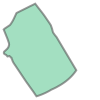

In [73]:
import geopandas as gpd
import numpy as np

oc = gadm_eez.loc[(gadm_eez['status'] == 'Overlapping claim') & (gadm_eez['domain'] == 'Marine'),]
#oc
#ter = gadm_eez.loc[(gadm_eez['domain'] == 'Terrestrial'),]
#ter
tst = oc.loc[oc['gid']==48950]
#tst

b = exterior_to_polygon(tst)
b

#print(tst.geometry.values[0])

#claimed_by = tst['claimed_by'].values.tolist()[0].split(', ')
#print(claimed_by)
#s = ter.loc[ter['iso3'].isin(['JPN'])]
#s

#b = tst.convex_hull
#tst.plot()
#b.plot()

#clip = gpd.clip(s,b)
#clip
#clip.plot()
#tst
#print(concat_strs(clip['source'].values[0], tst['source'].values[0], sep = ", "))


#gpd.GeoDataFrame()
#gpd.overlay(s, b, how='difference')

In [132]:
gpd.GeoDataFrame(
    {'iso3':[None],
     'un_code':[np.nan],
     'source': [concat_strs(clip['source'].values[0], tst['source'].values[0], sep = ", ")],
     'domain': ['Terrestrial'],
     'type_level': clip['type_level'].values,
     'status': tst['status'].values,
     'gid': [concat_strs(clip['gid'].values[0], tst['gid'].values[0], sep = "")],
     'geoname': tst['geoname'],
     'claimed_by': tst['claimed_by'].values,
     'geometry': clip['geometry'].values
}, crs='EPSG:4326')

,geometry,iso3,un_code,source,domain,type_level,status,gid,geoname,claimed_by
484,"MULTIPOLYGON (((146.17729 43.42937, 146.17842 ...",None,NaN,"GADM version 3.6, EEZ version 11",Terrestrial,Admin. 0,Overlapping claim,RUS48950,Overlapping claim Kuril Islands: Japan / Russia,"JPN, RUS"


In [127]:
tst['claimed_by']

484    JPN, RUS
Name: claimed_by, dtype: object

### Manual fixes

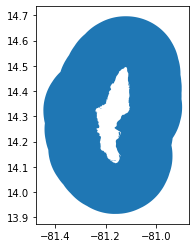

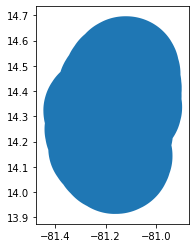

In [63]:
# Assign Quita sueños to EEZ
# This is a reef with a lighthouse and land is missing from GADM
# Possible improvement find polygon of land? 
import pandas as pd

# Get EEZ geometry
tst = gadm_eez.loc[gadm_eez['gid'] == '62598', ['geometry', 'iso3']]
# Get interior polygon
ply = interior_to_polygon(tst)
# Merge
gs = gpd.GeoDataFrame({'geometry':gpd.GeoSeries(ply), 'iso3':['COL']})
gs.crs = "EPSG:4326"
out = pd.concat([tst, gs], ignore_index=True).dissolve(by='iso3', aggfunc='first')
g = out.geometry.tolist()[0]
g
# Replace in main df
tst.plot()
gadm_eez.loc[gadm_eez['gid'] == '62598', ['geometry']] = [g]
gadm_eez.loc[gadm_eez['gid'] == '62598', ['geometry', 'iso3']].plot()



### Sanity checks

In [66]:
import country_converter as cc
import numpy as np
# Check all iso3 codes are valid or NaN
tst = cc.convert(names=gadm_eez['iso3'].dropna().tolist(), src = 'ISO3', to='ISO3', not_found=np.nan)
print("Any iso3 codes are invalid", pd.isna(tst).any())

Any iso3 codes are invalid False


In [71]:
# Check all un_codes codes are valid or NaN
un_gadm_eez = gadm_eez['un_code'].dropna()
print("In gadm_eez but not in UN states list:", list(set(un_gadm_eez).difference(un)))

In gadm_eez but not in UN states list: []


In [74]:
# Check for empty geometries
print("Any empty geometries?", gadm_eez.is_empty.any())

Any empty geometries? False


In [75]:
%%time
# Check for valid geometries
print("Are all geometries valid?", gadm_eez.is_valid.any())

Are all geometries valid? True


In [76]:
# Inspect df
gadm_eez

,iso3,un_code,source,domain,type_level,status,gid,geoname,claimed_by,geometry
0,ABW,533.0,GADM version 3.6,Terrestrial,Admin. 0,No overlapping claim,ABW,Aruba,None,"POLYGON ((-69.97820 12.46986, -69.97837 12.469..."
1,AFG,4.0,GADM version 3.6,Terrestrial,Admin. 0,No overlapping claim,AFG,Afghanistan,None,"POLYGON ((60.89944 29.83750, 60.89880 29.83780..."
2,AGO,24.0,GADM version 3.6,Terrestrial,Admin. 0,No overlapping claim,AGO,Angola,None,"MULTIPOLYGON (((11.69320 -16.63962, 11.69320 -..."
3,ALB,8.0,GADM version 3.6,Terrestrial,Admin. 0,No overlapping claim,ALB,Albania,None,"MULTIPOLYGON (((19.99181 39.77597, 19.99181 39..."
4,AND,20.0,GADM version 3.6,Terrestrial,Admin. 0,No overlapping claim,AND,Andorra,None,"POLYGON ((1.44083 42.58825, 1.44215 42.58904, ..."
...,...,...,...,...,...,...,...,...,...,...
496,None,NaN,EEZ version 11,Marine,EEZ 200NM,Overlapping claim,48997,Overlapping claim Chafarinas Islands: Spain / ...,"ESP, MAR","POLYGON ((-2.44181 35.18317, -2.44181 35.18153..."
497,None,NaN,EEZ version 11,Marine,EEZ 200NM,Overlapping claim,48947,Overlapping claim: Iran / United Arab Emirates,"ARE, IRN","POLYGON ((55.70431 26.15461, 55.66047 26.05965..."
498,None,NaN,EEZ version 11,Marine,EEZ 200NM,Overlapping claim,48956,Overlapping claim Doumeira Islands: Djibouti /...,"ERI, DJI","POLYGON ((43.25290 12.86159, 43.25460 12.85974..."
499,None,NaN,EEZ version 11,Marine,EEZ 200NM,Overlapping claim,48954,Overlapping claim Senkaku Islands: Japan / Chi...,"TWN, JPN, CHN","POLYGON ((124.94265 28.31348, 125.40085 27.067..."


In [40]:
#gadm_eez.loc[gadm_eez['iso3'] == 'ATA',]

,iso3,geometry,un_code,source,domain,type_level,status,gid,geoname,claimed_by
11,ATA,"MULTIPOLYGON (((177.91199 -59.59531, 177.91042...",10,GADM version 3.6,Terrestrial,Admin. 0,No overlapping claim,ATA,Antarctica,NaN
465,ATA,"POLYGON ((-45.48729 -57.18968, -45.46649 -57.1...",10,EEZ version 11,Marine,EEZ 200NM,No overlapping claim,8489,Antarctic 200NM zone beyond the coastline,NaN


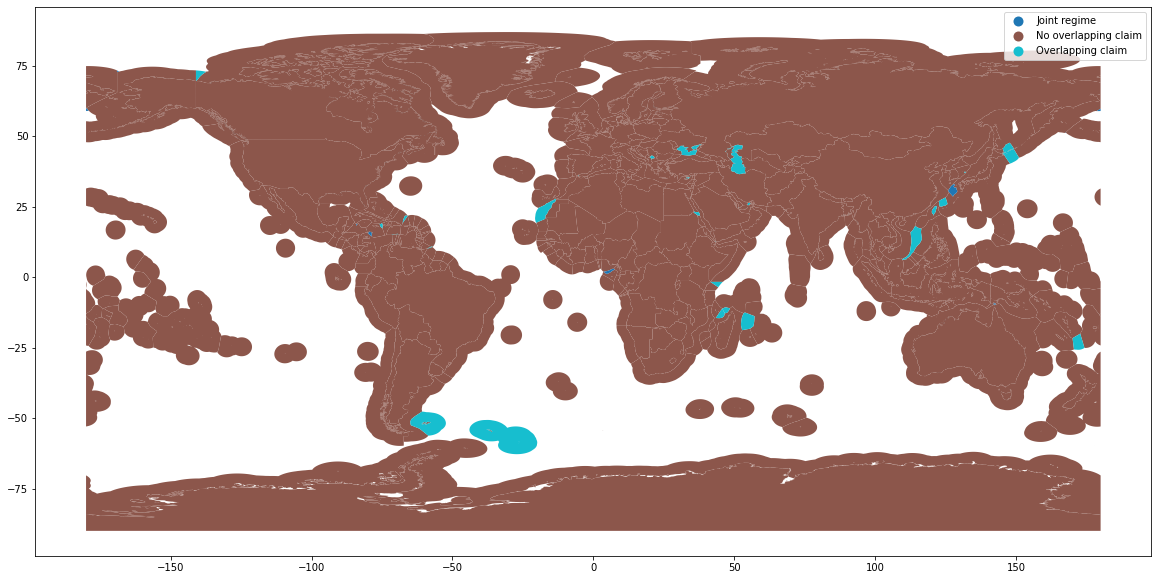

In [77]:
# Plot
gadm_eez.plot(column='status',figsize=(20,20), legend = True)

In [0]:
# Check it out
#import folium

#noc = folium.features.GeoJson(eez.cx[20.7:20.9,59.9:60.2].to_json()) 
#oc = folium.features.GeoJson(eez.loc[eez['pol_type'] == 'Overlapping claim'].to_json())
#jr = folium.features.GeoJson(eez.loc[eez['pol_type'] == 'Joint regime'].to_json())
#m = folium.Map([60, 20.8],zoom_start=7,tiles='cartodbpositron')
#folium.GeoJson(gadm_eez, name='GADM-EEZ').add_to(m)

#mapa.add_child(noc)
#mapa.add_child(oc)
#mapa.add_child(jr)
#m

## Write to file

#### General file naming convention

`[layer-name]-[layer-name]_version-[major number]-[minor number]_[processing options].[file type]`

For example:

`gadm-eez_version-0-1_clean.shp`

In [0]:
version = "1-0-0"
bn = f"gadm-eez_version-{version}"

In [0]:
# Write to ESRI SHP
gadm_eez.to_file(f"{bn}.shp", driver='ESRI Shapefile')

In [0]:
# Write to GeoJSON
#gadm_eez.to_file("f"{bn}.geojson", driver='GeoJSON', index=False)

In [0]:
# Write to CSV
#import shapely

# Write to file
#def write_to_csv(df, p, wkb=False): 
#  if wkb:
#    df['WKB'] = df.geometry.apply(lambda g: shapely.wkb.dumps(g, hex=True))
#  else:
#    df['WKT'] = df.geometry.apply(lambda g: shapely.wkt.dumps(g, trim=True))
#  df = df.drop(columns=["geometry"])
#  df.to_csv(p, index=False, na_rep="NA", chunk=100)

#write_to_csv(gadm_eez, f"{bn}.csv")  

## Fix geometry

Mapshaper [snap](https://github.com/mbloch/mapshaper/wiki/Command-Reference#snap) and [clean](https://github.com/mbloch/mapshaper/wiki/Command-Reference#clean) is applied to attempt to repair various kinds of abnormal geometry that might cause problems.

In [80]:
p = f"{bn}.shp"
o = f"{bn}_clean.shp"
!mapshaper-xl -i snap {p} -clean gap-fill-area=30km2 -o format=shapefile {o} force

Allocating 8 GB of heap memory
[i] Snapped 88516 points
[clean] Retained 501 of 501 features
[o] Wrote gadm-eez_version-1-0-0_clean.shp
[o] Wrote gadm-eez_version-1-0-0_clean.shx
[o] Wrote gadm-eez_version-1-0-0_clean.dbf
[o] Wrote gadm-eez_version-1-0-0_clean.prj


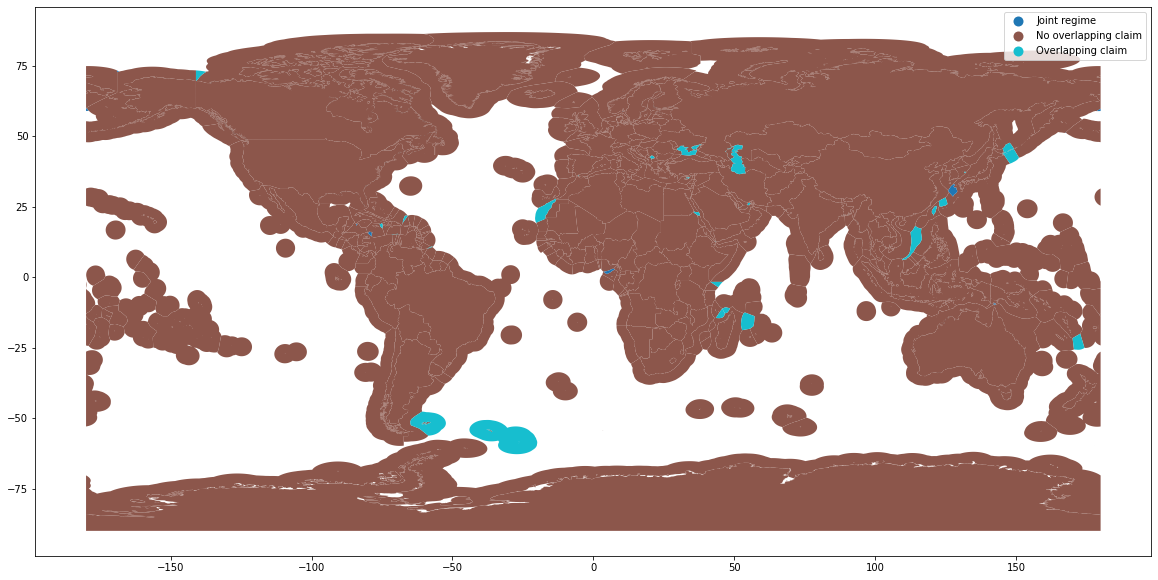

In [81]:
import geopandas as gpd

# check it
gadm_eez_clean = gpd.read_file(f"{bn}_clean.shp")
gadm_eez_clean.plot(column='status',figsize=(20,20), legend = True) 

In [0]:
# Write to file
out = gadm_eez_clean
out.to_file(f"{bn}.gpkg", layer='gadm-36-eez-11', driver="GPKG", index=False)

In [0]:
import zipfile
zip_file = zipfile.ZipFile(f"{bn}.gpkg.zip", 'w')
zip_file.write(f"{bn}.gpkg", compress_type=zipfile.ZIP_DEFLATED)
zip_file.close()

In [84]:
copy_gcs([f"{bn}.gpkg.zip"], [f"gs://mangrove_atlas/boundaries/{bn}.gpkg.zip"])

Processing: gsutil -m cp -r  gadm-eez_version-1-0-0.gpkg.zip gs://mangrove_atlas/boundaries/gadm-eez_version-1-0-0.gpkg.zip
Task created
Finished copy


## Dissolve geometries

In [18]:
copy_gcs([f"gs://mangrove_atlas/boundaries/{bn}.gpkg.zip"],[f"{bn}.gpkg.zip"])

Processing: gsutil -m cp -r  gs://mangrove_atlas/boundaries/gadm-eez_version-1-0-0.gpkg.zip gadm-eez_version-1-0-0.gpkg.zip
Task created
Finished copy


In [21]:
import geopandas as gpd

p = f"{bn}.gpkg.zip"
!unzip {p}
gadm_eez = gpd.read_file(f"{bn}.gpkg")

Archive:  gadm-eez_version-1-0-0.gpkg.zip
  inflating: gadm-eez_version-1-0-0.gpkg  


### Non-overlapping claims

In [0]:
# Write no overlapping claims to ESRI SHP
gadm_eez.loc[gadm_eez['status'] == 'No overlapping claim'].to_file(f"no_overlap.shp", driver='ESRI Shapefile')

In [24]:
%%time
!mapshaper-xl no_overlap.shp -dissolve un_code -o territories.shp

Allocating 8 GB of heap memory
[dissolve] Dissolved 456 features into 234 features
[o] Wrote territories.shp
[o] Wrote territories.shx
[o] Wrote territories.dbf
[o] Wrote territories.prj
CPU times: user 57.5 ms, sys: 35.1 ms, total: 92.6 ms
Wall time: 17.3 s


In [26]:
territories = gadm_eez = gpd.read_file("territories.shp")
territories

,un_code,geometry
0,533,"POLYGON ((-69.97820 12.46986, -69.97837 12.469..."
1,4,"POLYGON ((60.89944 29.83750, 60.89880 29.83780..."
2,24,"MULTIPOLYGON (((12.21127 -5.78652, 12.21125 -5..."
3,8,"POLYGON ((19.37464 41.85069, 19.37486 41.85069..."
4,20,"POLYGON ((1.44083 42.58825, 1.44215 42.58904, ..."
...,...,...
229,690,"POLYGON ((45.76750 -11.13972, 45.73142 -11.094..."
230,462,"POLYGON ((75.26443 -3.31123, 75.10398 -3.28582..."
231,520,"POLYGON ((165.92439 2.69385, 166.26913 2.57923..."
232,158,"POLYGON ((123.54476 22.25356, 123.39097 22.197..."


### Fill holes in overlapping

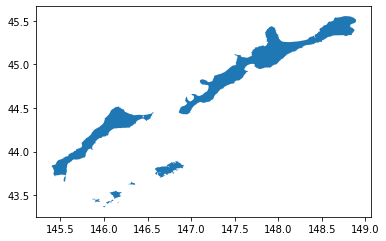

In [117]:
import geopandas as gpd
oc = gadm_eez.loc[(gadm_eez['status'] == 'Overlapping claim') & (gadm_eez['domain'] == 'Marine'),]
oc
tst = oc.loc[oc['gid']=='48950']
b = tst.convex_hull

#b = bounds_to_polygon(tst.total_bounds.tolist())
#print(b)
s = gadm_eez.loc[(gadm_eez['iso3'] == 'RUS') & (gadm_eez['domain'] == 'Terrestrial')]#.cx[b.minx:b.maxx,b.miny:b.maxy]
#s
gpd.clip(s,b).plot()

#interior_to_polygon(tst).plot()

## Create geo-array

### Notes on metadata
It is important to include metadata. We try to use netCDF CF style, see https://www.nodc.noaa.gov/data/formats/netcdf/v2.0/ , although any text can be added to attributes.

### Notes on versioning
Versioning uses this rule: `x.y.z`

Where:

    x = main version number, 1-~.
    y = feature number, 0-9. Increase this number if the change contains new features with or without bug fixes.
    z = hotfix number, 0-~. Increase this number if the change only contains bug fixes.

Example:

    For new application, the version number starts with 1.0.0.
    If the new version contains only bug fixes, increase the hotfix number so the version number will be 1.0.1.
    If the new version contains new features with or without bug fixes, increase the feature number and reset the hotfix number to zero so the version number will be 1.1.0. If the feature number reaches 9, increase the main version number and reset the feature and hotfix number to zero (2.0.0 etc)



In [0]:
copy_gcs([f"gs://mangrove_atlas/boundaries/{bn}.gpkg.zip"], [f"{bn}.gpkg.zip"])

In [0]:
import geopandas as gpd

# Load gdf
gdf = gpd.read_file(f"{bn}.gpkg.zip", layer='gadm-36-eez-11')
# Fix dtype
#gdf.loc[:,'un_code'] = gdf.loc[:,'un_code'].astype('Int64')
bnds = gdf.total_bounds
print(bnds)
print(gdf.dtypes)

In [0]:
# Create geo-array
# Add metadata using netCDF CF style, see https://www.nodc.noaa.gov/data/formats/netcdf/v2.0/
attrs = {
    "title" : "GADM-EEZ: Database of Global Administrative Areas (GADM), version 3.6 and Maritime Boundaries Geodatabase: Exclusive Economic Zones (200NM), version 11",
    "crs" : "EPSG:4326",
    "version": "1.0.0",
    "geospatial_lat_min": -180,
    "geospatial_lat_max" : 180,
    "geospatial_lon_min" : -90,
    "geospatial_lon_max" : 90,
    "history" : "Created by combining `gadm36_levels_gpkg:level0` and `MarineRegions:eez` downloaded from `https://biogeo.ucdavis.edu/data/gadm3.6` and `http://geo.vliz.be/geoserver/MarineRegions/ows?`. Geometries were converted to EPSG:4236. Selected columns were harmonised to create geometry type-levels organisation (`type_levels`). Standard ISO-3611-alpha3 codes, if applicable, were added to each geometry (`iso3`). Standard UN-Stats M.49 numerical codes, if applicable, were added to each geometry (`un_code`). Names, usually in English, were added to each geometry (`geonames`). Identification codes (`gid`) were added to each geometry; these were retained from the original datasets (`GID_0` and `mrgid`). The status of the geometry was classified into `No overlapping claims`, `Joint regime`, and `Overlapping claim` (`status`). ISO-3611-alpha3 codes of the states which claim the geometry were added as a comma-delimited list (`claimed_by`), note this list may not be exustive. The original dataset source was add to each geometry (`source`). The domain, terrestrial or marine, was added to each geometry (`domain`).",
    'keywords' : "Administrative areas, GADM, EEZ",
    "summary" : "This dataset represents terrestrial level 0 global administrative areas for 2018 combined with marine exclusive economic zones 2019. Each geometry was assigned a standard ISO-3611-alpha3 code (if it exists) and a UN M.49 numerical code (if it exists). The status of the geometry was classified into `No overlapping claims`, `Joint regime`, and `Overlapping claim` and ISO-3611-alpha3 codes of the states which claim the geometry added to the field `claimed_by`. For further details about the source layers see https://gadm.org/ , http://www.marineregions.org , and https://unstats.un.org/unsd/methodology/m49/.",
    "creator_institution" : "vizzuality.",
    "license" : ""}
coords = ['gid', 'geoname', 'type_level', 'iso3', 'un_code', 'source', 'domain', 'status']
dims = ['gid']
#chunks = {'admin_level':1, 'iso3':1}
gda = gdf_to_xarray(gdf, coords, dims, None, attrs)
gda 

## Export to remote ZARR

In [0]:
import zarr

# FIXME: how to remove serialisation error?
# Create remote ZARR
write_to_remote_zarr(gda, 'gadm-36-eez-11', root = "mangrove_atlas/gadm-eez.zarr")

## Check remote geo-array ZARR

In [0]:
%%time
import shapely

rgda = get_cached_remote_zarr('gadm-36-eez-11', root = "mangrove_atlas/gadm-eez.zarr", clear_cache=False)
# using set index and sel (crashes!)
#tst = rgda.set_index(x=['admin_level', 'iso3'])
#es = tst.sel(admin_level=4, iso3='ESP')

# using mask and where
mask = (rgda.iso3 == 'ESP') 
es = rgda.where(mask, drop=True)

# Convert to geodataframe
df = es.reset_coords().to_dataframe().dropna().reset_index()
geoms = [shapely.wkb.loads(g, hex=True) for g in es.geometry.values]
# Return as geopandas object, converting geometry to shapley objects
rgdf = gpd.GeoDataFrame(df, geometry = geoms)
rgdf.plot(column='domain',figsize=(10,10), legend = True)